In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import scipy.stats
from tqdm.notebook import tqdm
import random
from scipy.stats import ttest_ind

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
import itertools

import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as scistats

import pickle

import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torch.utils.data import DataLoader
import warnings
import re

In [2]:
from nilearn import plotting
from nilearn import image

# utilities

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

class PatientDataSet(Dataset):
    '''
    PyTorch Dataset for holding the brain scan data and clinical data of patients
    and loading it for use in machine learning algorithms and PyTorch neural networks
    
    attributes:
        df: DataFrame 
            The dataframe containing correlation matrices and clinical data of patients
        dataset_type: str
            The type of brain scan data we are working with
        brain_columns: Index
            Column names containing the brain data
        clinical_columns: Index 
            Column names containing the clinical data
        data_columns: Index
            Column names containing the trainable data
        target_column: Index
            Column name of the target data
        info_columns: Index
            Column names of data containing additional, nontrainable data
        transform
            The transform(s) to be applied to the data
    '''
    
    def __init__(self, df, patient_cols=[], info_cols=[], target_col=None, non_data_cols=[], transform=None):
        self.df = df
        brain_data_filter = ~(self.df.columns.to_series().isin(patient_cols + non_data_cols))
        self.brain_columns = self.df.columns[brain_data_filter]
        self.clinical_columns = self.df.columns[~brain_data_filter]
        target_col = [target_col]
        non_data = non_data_cols + info_cols + target_col
        data_col_filter = ~self.df.columns.isin(non_data)
        self.data_columns = self.df.columns[data_col_filter]
        target_col_filter = self.df.columns.isin(target_col)
        self.target_column = self.df.columns[target_col_filter]
        info_col_filter = self.df.columns.isin(info_cols)
        self.info_columns = self.df.columns[info_col_filter]
        self.transform = transform
    
    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        selected_rows = self.df.iloc[idx]
        
        data = selected_rows[self.data_columns]
        diagnosis = selected_rows[self.target_column]
        info = selected_rows[self.info_columns]
        clinical = selected_rows[self.clinical_columns]
        index = selected_rows.index

        sample = {'data':data, 'diagnosis':diagnosis, 'info':info, 
                  'clinical':clinical, 'index':index}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    # Returns the trainable data of the entire dataset
    def get_X(self):
        data = self.df[self.data_columns]
        return data
    
    # Returns the target data of the entire dataset
    def get_Y(self):
        diagnosis = self.df[self.target_column]
        return diagnosis
        

class GaussianNoise:
    '''
    A transform to be applied to a PatientDataSet that applies gaussian 
    noise to it
    
    attributes:
        mean: float
            The mean of the gaussian noise
        std_dev: float
            The standard deviation of the gaussian noise
        brain_columns: Index
            The columns of the DataFrame, which hold the brain
            scan data to which the gaussian noise should be applied
    '''
    
    def __init__(self, mean, std_dev, brain_columns):
        self.mean = mean
        self.std_dev = std_dev
        self.brain_columns = brain_columns
        
    def __call__(self, sample):
        shape = sample['data'][self.brain_columns].shape
        noise = np.random.normal(self.mean, self.std_dev, shape)
        
        data = sample['data']
        data_noisy = data.copy()
        data_noisy[self.brain_columns] += noise
        
        return {'data':data, 'data_noisy':data_noisy, 'diagnosis':sample['diagnosis'],
                'info':sample['info'], 'clinical':sample['clinical'],
                'index':sample['index']}
        

class ToTorchFormat:
    '''
    A transform to be applied to a PatientDataSet that converts a
    given data sample to a PyTorch format
    '''
    
    def __call__(self, sample):
        data = sample['data'].astype('float64')
        data_formatted = torch.from_numpy(data.to_numpy()).float()
        diagnosis = sample['diagnosis'].astype('int64')
        diagnosis_formatted = torch.from_numpy(diagnosis.to_numpy())
        info = sample['info']
        if type(info) is pd.DataFrame:
            info_formatted = info.to_dict(orient='list')
        else:
            info_formatted = info.to_dict()
        clinical = sample['clinical']
        if type(clinical) is pd.DataFrame:
            clinical_formatted = clinical.to_dict(orient='list')
        else:
            clinical_formatted = clinical.to_dict()
        sample_new = {'data':data_formatted, 
                      'diagnosis':diagnosis_formatted, 
                      'info':info_formatted, 'clinical':clinical_formatted}
        if 'data_noisy' in sample.keys():
            data_noisy = sample['data_noisy'].astype('float64')
            data_noisy_formatted = torch.from_numpy(data_noisy.to_numpy()).float()
            sample_new['data_noisy'] = data_noisy_formatted
        return sample_new
        

'''
Dictionaries holding the maps for sex and diagnosis
'''
sex_dict = {'M':0, 'F':1} 

def clean_cols(df, subj=None, sex=None):
    '''
    Cleans the SubjectID, Sex, and Diagnosis columns by mapping them
    to their desired values and types
    
    params:
        df: DataFrame
            The DataFrame to clean the columns for
        subj: str (default = None)
            If not None, the column to map for subject id
        sex: str (default = None)
            If not None, the column to map for sex 
            
    return:
        DataFrame
            The DataFrame with the columns cleaned
    '''
    
    if subj is not None:
        df[subj] = df[subj].apply(str)
    if sex:
        df[sex] = df[sex].map(sex_dict)
    
    return df


def scale_features(df, scaler_type='robust', cols_to_ignore = []):
    '''
        Scales all relevant feature columns using the specified scaler
        
        params:
            df: DataFrame
                The DataFrame to which to apply feature scaling
            scaler_type: str (default = 'robust')
                The string specifying the type of scaler to use
            cols_to_ignore: list (default = [])
                A list of column names to not apply scaling to
                
        return:
            DataFrame
                The DataFrame with scaled features
    '''
      
    if scaler_type.lower() == 'robust':
        scaler = RobustScaler()
    elif scaler_type.lower() == 'standard':
        scaler = StandardScaler()
    elif scaler_type.lower() == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise Exception("Invalid scaler type given. Only 'standard', 'robust', and 'minmax' are accepted.")
    for col in df.columns[~df.columns.isin(cols_to_ignore)]:
        col_np = df[col].to_numpy().reshape(-1,1)
        scaler.fit(col_np)
        df[col] = scaler.transform(col_np)
        
    return df
    

def apply_network_mask(df, network_name, mask_val=1):
        
    network_labels = pd.read_csv('power264_networklabels.csv')
    label_list = network_labels['NetworkLabel'].unique()
    if network_name not in label_list:
        raise Exception('Network Label "{}" not in label_list'.format(name))
    label_combinations = list(itertools.combinations_with_replacement(label_list, 2))
    label_combinations = [combo for combo in label_combinations if (combo[0] == network_name or combo[1] == network_name)]
    for label1, label2 in label_combinations:
        ROI_match_filt = (network_labels['NetworkLabel'].str.fullmatch(label1) | 
                         network_labels['NetworkLabel'].str.fullmatch(label2))
        ROI_indices = network_labels['ROI'][ROI_match_filt]
        ROI_mat_indices = []
        for x in ROI_indices:
            for y in ROI_indices:
                ROI_mat_indices.append("ROI{}-ROI{}".format(x-1,y-1))
        
        ROI_mat_indices = [roi for roi in ROI_mat_indices if
                           roi in df.columns.tolist()]
        
        df[ROI_mat_indices] = mask_val
    
    return df    


def preprocess_df(df, **kwargs):
    '''
        A utility function for scaling features and/or reducing the ROI if desired
        
        **kwargs:
            scale_features: str (default = None)
                Whether to scale features and if so, which scaler to use
        
        return:
            DataFrame
                The DataFrame with desired preprocessing applied
    '''
    
    scale_feat = kwargs.get('scale_features', None)
    cols_to_ignore = kwargs.get('cols_to_ignore', [])
    network_mask = kwargs.get("apply_network_mask", False)
    network = kwargs.get("network", None)
    network_mask_val = kwargs.get("network_mask_val", 1)
    filter_equals = kwargs.get('filter_equals', {})
        
    if network_mask:
        df = apply_network_mask(df, network, network_mask_val)
        
    if scale_feat:
        df = scale_features(df, scale_feat, cols_to_ignore=cols_to_ignore)
    
    for col, val in filter_equals.items():
        filter = df[col] == val
        df = df[filter]
        
    return df

def split_df(df, **kwargs):
    '''
        A function for splitting the DataFrame either by choosing a selected number of rows
        or by doing a train test split by percent
        
        **kwargs:
            n_rows: int (default = None)
                If not None, the number of rows to take from the DataFrame
            randomize: bool (default = False)
                Whether to shuffle the rows
            random_seed: int (deafult =  None)
                If not None, the random seed to plug into the random shuffle
            train_test_split: bool (default = False)
                Whether to perform a train test split by percent
            percent_split: float(default = None)
                The percent to split by between 0.0 and 1.0
            validation_split: float(default = None)
                The percent from the training set to use for the validation set
        
        return:
            DataFrame: if train_test_split is False
            DataFrame, DataFrame: if train_test_split is True
    '''
    
    n_rows = kwargs.get('n_rows', None)
    randomize = kwargs.get('randomize', False)
    random_seed = kwargs.get('random_seed', None)
    train_test_split = kwargs.get('train_test_split', False)
    percent_split = kwargs.get('percent_split', None)
    validation_split = kwargs.get('validation_split', None)
    
    if n_rows:
        n_rows = min(n_rows, len(df.index)-1)
    
    if not randomize:
        if train_test_split:
            if percent_split:
                if n_rows:
                    split = int(percent_split*n_rows)
                    train_df = df.iloc[0:split]
                    test_df = df.iloc[split:n_rows]
                else:
                    split = int(percent_split*(len(df.index)-1))
                    train_df = df.iloc[0:split]
                    test_df = df.iloc[split:]
                if validation_split:
                    split = int(validation_split*(len(train_df.index)-1))
                    val_df = train_df.iloc[0:split]
                    train_df = train_df.iloc[split:]
            else:
                raise Exception("Wanted train test split, but no split was given. Must set 'percent_split' as an argument.")
            
            if not validation_split:
                return train_df, test_df
            else:
                return train_df, val_df, test_df
            
        else:
            if percent_split:
                if n_rows:
                    split = int(percent_split*n_rows)
                else:
                    split = int(percent_split*(len(df.index)-1))
                df = df.iloc[0:split]
            elif n_rows:
                df = df.iloc[0:nrows]
            
            return df
            
    else:
        if random_seed:
            np.random.seed(random_seed)
        
        if train_test_split:
            if percent_split:
                if n_rows:
                    split = int(percent_split*n_rows)
                    df_indices = np.random.choice(df.index, n_rows)
                else:
                    split = int(percent_split*(len(df.index)-1))
                    df_indices = np.random.choice(df.index, len(df.index))
                train_df = df.loc[df_indices[0:split]]
                test_df = df.loc[df_indices[split:]]
                
                if validation_split:
                    split = int(validation_split*(len(train_df.index)-1))
                    val_df = train_df.iloc[0:split]
                    train_df = train_df.iloc[split:]
            else:
                raise Exception("Wanted train test split, but no split was given. Must set 'percent_split' as an argument.")
            
            if not validation_split:
                return train_df, test_df
            else:
                return train_df, val_df, test_df
            
        else:
            if percent_split:
                if n_rows:
                    split = int(percent_split*n_rows)
                else:
                    split = int(percent_split*(len(df.index)-1))
                df_indices = np.random.choice(df.index, split)
                df = df.loc[df_indices]
            elif n_rows:
                df_indices = np.random.choice(df.index, n_rows)
                df = df.loc[df_indices]
            else:
                df_indices = np.random.choice(df.index, len(df.index))
                df = df.loc[df_indices]
            
            return df
            

def load_corr_clinical(csv_path, **kwargs):
    '''
    Loads the DataFrame containing RS correlation matrix and clinical data for
    subjects
    
    params:
        csv_path: str
            The path to the csv file containing the merged RS correlation matrix and clinical data
    
    **kwargs:
        patient_type: str (default = 'all')
            The patient population to load
        clean_cols: bool (default = True)
            Whether to clean the Sex and Diagnosis columns or not
        scale_features: str (default = None)
                Whether to scale features and if so, which scaler to use
            
    return: 
        DataFrame
            The correlation and clinical data for the patients of the
            desired patient types with preprocessing applied
    '''
    
    patient_type = kwargs.get('patient_type', 'all')
    patient_type = patient_type.lower()
    clean_cols_ = kwargs.get('clean_cols', True)
    
    subject_col = kwargs.get('subject_col', None)
    age_col = kwargs.get('age_col', None)
    sex_col = kwargs.get('sex_col', None)
    target_col = kwargs.get('target_col', None)
    
    diag_dict = {'Control':0, 'Autism':1}

    chunksize = 10**3
    df = None

    for i,chunk in enumerate(pd.read_csv(csv_path, chunksize=chunksize)):
        
        if clean_cols_:
            chunk = clean_cols(chunk, subj=subject_col, sex=sex_col)
        else:
            chunk = clean_cols(chunk, subj=subject_col)
            
        if df is None:
            df = chunk
        else:
            df = pd.concat([df, chunk])
    
    patient_type = patient_type.lower()
    if patient_type != 'all':
        if patient_type == 'control':
            patient_filter = df[target_col] == diag_dict['Control']
            df = df[patient_filter]
        elif patient_type == 'autism':
            patient_filter = df[target_col] == diag_dict['Autism']
            df = df[patient_filter]
        else:
            raise ValueError("Invalid argument {} for kwarg 'patient_type'. Only accepts 'all', 'control', or 'autism'".format(patient_type))
    
    df = preprocess_df(df, **kwargs)
    
    df[subject_col] = df[subject_col].apply(str)
    df[age_col] = df[age_col].astype(float)
    
    df.reset_index(drop=True, inplace=True)
    
    return df
    

def generate_datasets(csv_path, **kwargs):
    '''
    Generates the PatientDataSets of the desired format
    
    params:
        csv_path: str
            Path to csv file containing brain scan and clinical data
    
    **kwargs:
        non_data_cols: list (default = [])
            Additional columns that should not be considered data
        patient_type: str (default = 'all')
            The patient population to load
        scale_features: str (default = None)
            Whether to scale features and if so, which scaler to use
        n_rows: int (default = None)
            If not None, the number of rows to take from the DataFrame
        randomize: bool (default = False)
            Whether to shuffle the rows
        random_seed: int (deafult =  None)
            If not None, the random seed to plug into the random shuffle
        train_test_split: bool (default = False)
            Whether to perform a train test split by percent
        percent_split: float (default = None)
            The percent to split by between 0.0 and 1.0
            
    
    return:
        PatientDataSet: if train_test_split is False
        PatientDataSet, PatientDataSet: if train_test_split is True 
    '''
    
    patient_cols=kwargs.get("patient_cols", [])
    info_cols=kwargs.get("info_cols", [])
    target_col=kwargs.get("target_col", None)
    non_data_cols=kwargs.get("non_data_cols", [])
    
    kwargs['cols_to_ignore'] = non_data_cols
    
    df = load_corr_clinical(csv_path, **kwargs)
    
    dfs = split_df(df, **kwargs)
    
    if type(dfs) is tuple:
        if len(dfs) == 2:
            train_dataset = PatientDataSet(dfs[0], patient_cols=patient_cols, info_cols=info_cols, target_col=target_col, non_data_cols=non_data_cols)
            test_dataset = PatientDataSet(dfs[1], patient_cols=patient_cols, info_cols=info_cols, target_col=target_col, non_data_cols=non_data_cols)
            return train_dataset, test_dataset
        elif len(dfs) == 3:
            train_dataset = PatientDataSet(dfs[0], patient_cols=patient_cols, info_cols=info_cols, target_col=target_col, non_data_cols=non_data_cols)
            val_dataset = PatientDataSet(dfs[1], patient_cols=patient_cols, info_cols=info_cols, target_col=target_col, non_data_cols=non_data_cols)
            test_dataset = PatientDataSet(dfs[2], patient_cols=patient_cols, info_cols=info_cols, target_col=target_col, non_data_cols=non_data_cols)
            return train_dataset, val_dataset, test_dataset
    else:
        return PatientDataSet(dfs, patient_cols=patient_cols, info_cols=info_cols, target_col=target_col, non_data_cols=non_data_cols)

In [4]:

def plot_loss(net_name, plot_title=None, stat_label_dict=None, save_name=None):
    '''
    For plotting and saving the loss function
    
    params:
        net_name: str
            The name of the network
        plot_title: str (default = None)
            If not None, the title to give the plot
            Otherwise, uses the name of the network
        stat_label_dict: dict (default = None)
            If not None, renames the desired stats (keys)
            to the desired labels(values) in the plot legend
            Otherwise, uses the default stat names for the labels
        save_name: str (default = None)
            If not None name used when saving the plots
            Otherwise uses the net name
    '''
    fig, ax1 = plt.subplots(1,1,figsize=(16,12), dpi=200)
    stat_path = os.path.join("vae_nets", net_name)
    st = Stats(path=stat_path)
    if stat_label_dict is None:
        stat_label_dict = {k : k for k in st.stats.keys}
    stat_list_dict = {}
    for stat_label_orig, stat_label_new in stat_label_dict.items():
        stat_vals = st[stat_label_orig]
        x = list(stat_vals.keys())
        y = list(stat_vals.values())
        if type(y[0]) in [list, tuple]:
            ys = list(zip(*y))
            stat_labels = stat_label_new
            for stat_label_new, y in zip(stat_labels, ys):
                ax1.plot(x, y, label=stat_label_new)
        else:
            ax1.plot(x, y, label=stat_label_new)
    ax1.set_ylabel('Loss Divided by # Features')
    ax1.set_xlabel('Epoch')
    if plot_title is not None:
        ax1.set_title(plot_title)
    else:
        ax1.set_title("{} Loss".format(net_name))
    ax1.legend()
    if save_name is None:
        save_name = net_name
    plots_dir = os.path.join("plots", "loss")
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    plt.savefig(os.path.join(plots_dir, "{}.png".format(save_name)))
    plt.show()


def plot_latent_individual(df, type_name, **kwargs):
    '''
    For plotting and saving individual latent distributions
    
    params:
        choices: list[int] (default = None)
            If not None, individuals of the selected indices
            are selected from the dataframe
            Otherwise, they are selected at random
        n_choices: int (default = 5)
            If indices is None, the number of individuals to select
            Otherwise, this argument is not used
        diagnosis: str (default = None)
            If not None, chooses the matching diagnosis type
            ('Control' or 'PTSD')
        sharex: bool (default = False)
            Whether the x axis of plots should be shared
        sharey: bool (default = False)
            Whether the y axis of plots should be shared
        run_id: int (default = 0)
            An indicator used for saving more than one plot
        save_name: str (default = None)
            If not None name used when saving the plots
            Otherwise uses brain scan type and diagnosis     
    '''
    choices = kwargs.get("choices", None)
    n_choices = kwargs.get("n_choices", 5)
    diagnosis = kwargs.get("diagnosis", None)
    sharex = kwargs.get("sharex", False)
    sharey = kwargs.get("sharey", False)
    run_id = kwargs.get("run_id", 0)
    save_name = kwargs.get("save_name", None)
    
    diagnosis_map = {'control':0, 'ptsd':1}
    
    if diagnosis is not None:
        df = df[df['Diagnosis'] == diagnosis_map[diagnosis.lower()]]
    
    if not choices:
        choices = np.random.randint(len(df.index), size=n_choices)
        
    mus = df[df.columns[df.columns.to_series().str.contains('mu')]]
    mus = mus.iloc[choices]
    logvars = df[df.columns[df.columns.to_series().str.contains('logvar')]]
    logvars = logvars.iloc[choices]
    patient_info = df['Site'] + "_" + df['SubjectID']
    patient_info = patient_info.iloc[choices]
    variances = logvars.apply(np.exp)
    
    diag_types = ["Control", "PTSD"]
    
    fig, axs = plt.subplots(len(choices), sharex=sharex, sharey=sharey, figsize=(16,12), dpi=300)
    if not diagnosis:
        fig.suptitle("{} Latents".format(type_name))
    else:
        fig.suptitle("{} {} Latents".format(diagnosis, type_name))
        
    fig.tight_layout()
    
    for i, ax in enumerate(axs):
        mu_curr = mus.iloc[i]
        variance_curr = variances.iloc[i]
        patient = patient_info.iloc[i]
        for mu, var in zip(mu_curr.tolist(), variance_curr.tolist()):
            std_dev = np.sqrt(var)
            x = np.linspace(mu-3*std_dev, mu+3*std_dev, 100)
            y = scistats.norm.pdf(x, mu, std_dev)
            ax.set_ylabel(patient, fontsize=10)
            ax.plot(x, y)
    
    plots_dir = os.path.join("plots", "latents")
    
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
        
    if save_name is None:
        if diagnosis is not None:
            save_name = "{}_{}_latent".format(type_name, diagnosis.lower())
        else:
            save_name = "{}_{}_latent".format(type_name)
    save_name = "{}_{}.png".format(save_name, run_id)
    
    plt.savefig(os.path.join(plots_dir, save_name), bbox_inches='tight')
    plt.show()


def plot_latent_average(df, type_name, **kwargs):
    '''
    For plotting and saving averaged latent distributions over desired column
    
    params:
        choices: list[int] (default = None)
            Indices of unique elements in column of interest to be selected
        diagnosis: str  (default = None)
            If not None, chooses the matching diagnosis type
            ('Control' or 'PTSD')
        avg_col: str (default = 'Site')
            The column name over which to average
            ('Site', 'Age', 'Sex', or 'Diagnosis')
        sharex: bool (default = False)
            Whether the x axis of plots should be shared
        sharey: bool (default = False)
            Whether the y axis of plots should be shared
        x_range: tuple[int] (default = (-10, 10))
            The left and right bounds for the x axis
        run_id: int (default = 0)
            An indicator used for saving more than one plot
        save_name: str (default = None)
            If not None name used when saving the plots
            Otherwise uses brain scan type and diagnosis     
    '''
    choices = kwargs.get("choices", None)
    diagnosis = kwargs.get("diagnosis", None)
    avg_col = kwargs.get("avg_col", 'Site')
    sharex = kwargs.get("sharex", False)
    sharey = kwargs.get("sharey", False)
    x_range = kwargs.get("x_range", (-10, 10))
    run_id = kwargs.get("run_id", 0)
    save_name = kwargs.get("save_name", None)
    
    diagnosis_map = {'control':0, 'ptsd':1}
    
    if diagnosis is not None:
        df = df[df['Diagnosis'] == diagnosis_map[diagnosis.lower()]]
        
    df_mean = df.groupby(by=[avg_col]).mean()
        
    mus = df_mean[df_mean.columns[df_mean.columns.to_series().str.contains('mu')]]
    if choices:
        mus = mus.iloc[choices]
    logvars = df_mean[df_mean.columns[df_mean.columns.to_series().str.contains('logvar')]]
    if choices:
        logvars = logvars.iloc[choices]
    patient_info = df_mean.index
    if choices:
        patient_info = patient_info[choices]
    variances = logvars.apply(np.exp)
    
    if choices is None:
        n_plots = len(df_mean.index)
    else:
        n_plots = len(choices)
        
    fig, axs = plt.subplots(n_plots, sharex=sharex, sharey=sharey, figsize=(16,12), dpi=300)
    if not diagnosis:
        fig.suptitle("{} Latents".format(type_name))
    else:
        fig.suptitle("{} {} Latents".format(diagnosis, type_name))
        
    fig.tight_layout()
    
    for i, ax in enumerate(axs):
        mu_curr = mus.iloc[i]
        variance_curr = variances.iloc[i]
        patient = patient_info[i]
        for mu, var in zip(mu_curr.tolist(), variance_curr.tolist()):
            std_dev = np.sqrt(var)
            x = np.linspace(x_range[0], x_range[1], 250)
            y = scistats.norm.pdf(x, mu, std_dev)
            ax.plot(x,y)
            ax.set_ylabel(patient, fontsize=10)
    
    plots_dir = os.path.join("plots", "latents")
    
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
        
    if save_name is None:
        if diagnosis is not None:
            save_name = "{}_{}_latent_{}_avg".format(type_name, diagnosis.lower(), avg_col.lower())
        else:
            save_name = "{}_latent_{}_avg".format(type_name, avg_col.lower())
    save_name = "{}_{}.png".format(save_name, run_id)
    
    plt.savefig(os.path.join(plots_dir, save_name), bbox_inches='tight')
    plt.show()

In [5]:

class Log:
    '''
    A general logging utility
    
    attributes:
        log_name : str
            The filename for the log
        log_path : str
            The path for the log file
        curr_str : str
            The string being tracked currently
        total_str : str
            The total log file string
        should_log : bool
            Whether to log currently
        overwrite : bool
            Whether to overwrite the log file if it exists
    
    methods:
        enable()
            Enables logging
        disable()
            Disables logging
        clear()
            Clears the log entirely
        set_name(name)
            Sets the name of the log file
        set_path(path)
            Sets the path of the log file
        get_log()
            Returns the entire log
        print_log
            Prints the entire log
        save
            Saves the log to 'log_path/log_name'
        print_and_log
            Prints the specified arguments and then adds them
            as a string to the log
    '''
        
        
    def __init__(self, log_name='log.txt', log_path = '.', should_log=True, overwrite=True):
        '''
        params:
            log_name: str (default = 'log.txt')
                The name of the log file
            log_path: str (default = '.')
                The path of the log file
            should_log: bool (default = True)
                Whether to log currently
            overwrite: bool (default = True)
                Whether to overwrite the log file if it exists    
        '''
        
        self.log_name = log_name
        self.log_path = log_path
        self.curr_str = ""
        self.total_str = ""
        self.should_log = should_log
        self.overwrite = overwrite
        
    def enable(self):
        '''
        Enables logging
        '''
        
        self.should_log = True
        
    def disable(self):
        '''
        Disables logging
        '''
        
        self.should_log = False
        
    def clear(self):
        '''
        Clears the log entirely
        '''
        
        self.curr_str = ""
        self.total_str = ""
        
    def set_name(self, name):
        '''
        Sets the name of the log file
        
        params:
            name: str
                The new log file name
        '''
        
        self.log_name = name
        
    def set_path(self, path):
        '''
        Sets the path of the log file
        
        params:
            path: str
                The new log file path
        '''
        
        self.log_path = path
        
    def get_log(self):
        '''
        Returns the entire log
        
        return:
            str
                The entire log as a string
        '''
        
        return self.total_str
        
    def print_log(self):
        '''
        Prints the entire log
        '''
        
        print(self.total_str)
        
    def save(self):
        '''
        Saves the log to 'log_path/log_name'
        If self.overwrite, then the current log file is overwritten
        Otherwise, the current log file is appended to
        '''
        
        if self.should_log:
            fpath = os.path.join(self.log_path, self.log_name)
            if self.overwrite:
                with open(fpath, 'w+') as logfile:
                    logfile.write(self.total_str)
            else:
                with open(fpath, 'a') as logfile:
                    logfile.write(self.curr_str)
                self.curr_str = ""
                
    def print_and_log(self, *args, **kwargs):
        '''
        Prints and adds the current arguments to the log as a string
        If self.should_log, then the arguments are also logged
        Otherwise, they are solely printed
        '''
        if self.should_log:
            new_str= ""
            for s in args:
                new_str += str(s)
            new_str += '\n'
            self.curr_str += new_str
            self.total_str += new_str
            print(*args, **kwargs)
        else:
            print(*args, **kwargs)
            return None
            

class Stats:
    '''
    A general utility for tracking stats
    
    attributes:
        filename: str
            The name of the stats file
        path:
            The path of the stats file
        stats:
            The dictionary holding the stats
            
    methods:
        clear_stat(statname)
            Clears the stat information for the stat of the given name
        delete_stat(statname)
            Deletes the stat completely
        track_stat(statname, key, val)
            Tracks the stat of the given name with a given key value pair
        set_name(name)
            Sets the name of the stat file
        set_path(path)
            Sets the path of the stat file
        save()
            Saves the stats to 'path/filename'
            
    '''
    
    def __init__(self, filename='stats', path='.', load=True):
        '''
        params:
            filename: str (default = 'stats')
                The name of the stats file
            path: str (default = '.')
                The path of the stats file
            load: bool (default = True)
                Whether to load the stats file
        '''
        
        # Want to ensure stats files have .stt extension
        fname, fext = os.path.splitext(filename)
        if fext != ".stt" and fext != "":
            raise Exception("Filename '{}' does not have correct extension ('{}' instead of '.stt')".format(filename, fext))
        if fext != ".stt":
            self.filename = fname + ".stt"
            
        self.path = path
        
        filepath = os.path.join(self.path, self.filename)
        
        if load and os.path.exists(filepath):
            with open(filepath, 'rb') as pickle_file:
                self.stats = pickle.load(pickle_file)
        else:
            if load:
                print("Warning: You are trying to load a stats file '{}' that doesn't exist.".format(os.path.abspath(filepath))) 
            self.stats = {}
            
    def clear_stat(self, statname):
        '''
        Clears the stat information for the stat of the given name
        
        params:
            statname: str
                The name of the stat to be cleared
        '''
        
        if statname in self.stats:
            self.stats[statname] = {}
            
    def delete_stat(self, statname):
        '''
        Deletes the stat completely
        
        params:
            statname: str
                The name of the stat to be deleted
        '''
        
        del stats[statname]
        
    def track_stat(self, statname, key, val):
        '''
        Tracks the stat of the given name with a given key value pair
        
        params:
            statname
                The name of the stat to track
            key
                The current key for the given stat
            val
                The value at that current key
        '''
        
        if statname not in self.stats:
            self.stats[statname] = {}
        self.stats[statname][key] = val
    
    def set_name(self, name):
        '''
        Sets the name of the stats file
        
        params:
            name: str
                The new stats file name
        '''
        
        self.filename = name
        
    def set_path(self, path):
        '''
        Sets the path of the stats file
        
        params:
            path: str
                The new stats file path
        '''
        
        self.path = path
        
    def save(self):
        '''
        Saves the stats to 'path/filename'
        '''
        
        filepath = os.path.join(self.path, self.filename)
        with open(filepath, 'wb') as pickle_file:
            pickle.dump(self.stats, pickle_file)
    
    def __getitem__(self, key):
        
        return self.stats[key]
    
    def __setitem__(self, key, val):
        
        self.stats[key] = val

In [6]:

# Network naming stuff
network_ext = '.nn'
network_name_fstr = '{}_{}' + network_ext

models_path = 'vae_nets'


def get_model_path(model_name):
    '''
    Returns the model path for the specified model name
    
    params:
        model_name: str
            The name of the model to get the path for
    
    return:
        str
            The path to the model folder
    '''
    return os.path.join(models_path, model_name)
    

def make_model_path(model_name):
    '''
    Creates the model folder for the specified model name
    
    params:
        model_name: str
            The name of the model to get the path for
    
    return:
        str
            The path to the model folder
    '''
    
    path = get_model_path(model_name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path


class NetworkMetadata:
    '''
    For saving metadata about the network so it can easily be loaded
    
    attribs:
        model_name: str
            The name of the model to save metadata on
        input_size: int
            The size of the input layer
        hidden_size: int
            The size of the hidden layer
        latent_size: int
            The size of the latent encoded layer
        activations: tuple
            The tuple of activation functions for the network
            
    methods:
        save()
            Saves the metadata to a file
        load()
            Loads the metadata from a file
    
    static methods:
        exists(model_name)
            Returns whether the model exists or not
    '''
    
    filename = 'netinfo.mtd'
    
    def __init__(self, model_name, input_size=None, hidden_size=None, latent_size=None, activations=None):
        self.model_name = model_name
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.activations = activations
        
    def set_data(input_size, hidden_size, latent_size, activations):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.activations = activations
    
    def save(self):
        model_path = get_model_path(self.model_name)
        metadata_path = os.path.join(model_path, NetworkMetadata.filename)
        with open(metadata_path, 'w+') as f:
            f.write('model_name: {}\n'.format(self.model_name))
            f.write('input_size: {}\n'.format(self.input_size))
            f.write('hidden_size: {}\n'.format(self.hidden_size))
            f.write('latent_size: {}\n'.format(self.latent_size))
            f.write('activations: {}\n'.format(', '.join(self.activations)))
    
    def load(self):
        model_path = get_model_path(self.model_name)
        metadata_path = os.path.join(model_path, NetworkMetadata.filename)
        with open(metadata_path) as f:
            for line in f.readlines():
                line = line.replace('\n', '')
                linesplit = line.split(': ')
                line_name = linesplit[0]
                line_data = linesplit[1]
                if line_name == 'input_size':
                    self.input_size = int(line_data)
                elif line_name == 'hidden_size':
                    self.hidden_size = int(line_data)
                elif line_name == 'latent_size':
                    self.latent_size = int(line_data)
                elif line_name == 'activations':
                    self.activations = line_data.split(', ')
        
    @staticmethod
    def exists(model_name):
        model_path = get_model_path(model_name)
        metadata_path = os.path.join(model_path, NetworkMetadata.filename)
        return os.path.exists(metadata_path)


def save_network(model, model_name, idx, log=None):
    '''
    Saves the specified model
    
    params:
        model: VAE
            The model to save
        model_name: str
            The name of the model to save to
        idx: int
            The current epoch at which this model is training
        log: Log (default = None)
            The Log to which to log the saving operation
    '''
    
    path = get_model_path(model_name)
    if not os.path.exists(path):
        raise Exception("Path for network '{}' does not exist, please call make_model_path first!".format(path))
    save_fpath = os.path.join(path, network_name_fstr.format(model_name, idx))
    torch.save(model.state_dict(), save_fpath)
    if not NetworkMetadata.exists(model_name):
        metadata = NetworkMetadata(model_name, model.input_size, model.hidden_size, model.latent_size, model.activations_str)
        metadata.save()
    if log:
        log.print_and_log("Saving model to ", save_fpath)
    else:
        print("Saving model to ", save_fpath)


def get_file_index(file):
    '''
    Used to get the indices of files that have a number at
    the end. (Used for getting epoch of model checkpoints)
    
    params:
        file: str
            The name of the file to get the index from
    
    return:
        int
            The index of the file
    '''
    filename, _ =  os.path.splitext(file)
    idx = re.findall('[0-9]+', filename)[-1]
    return int(idx)


def load_network(model_name, model=None, idx=None, log=None):
    '''
    Loads the model of the specified name's state into the specified model
    
    params:
        model_name: str
            The name of the model to load the state from
        model: VAE (default = None)
            If not None model to load the state to
            Otherwise, load model from metadata
        idx: int (default = None)
            The epoch from which to load the model
        log: Log (default = None)
            The Log to which to log the loading operation
    '''
        
    path = os.path.join("vae_nets", model_name)
    if not os.path.exists(path):
        raise Exception("Model by model_name '{}' does not exist!".format(model_name))
    files = [f for f in os.listdir(path) if model_name in f and '.nn' in f]
    if not files:
        raise Exception("Model directory for '{}' exists, but no saved networks found inside the directory!".format(model_name))
    if idx is None:
        files_sorted = sorted(files, key=lambda f : get_file_index(f), reverse=True)
        model_file = files_sorted[0]
    else:
        file_target = network_name_fstr.format(model_name, idx)
        if file_target in files:
            model_file = file_target
        else:
            raise Exception("Model directory for '{}' exists, but no network at epoch {} found inside the directory!".format(model_name, idx))
    
    model_path = os.path.join(path, model_file)
    
    if model is None:
        if NetworkMetadata.exists(model_name):
            metadata = NetworkMetadata(model_name)
            metadata.load()
            model = VAE(metadata.input_size, metadata.hidden_size, metadata.latent_size, metadata.activations)
    
    if model is None:
        raise Exception("No model was provided to load state into and metadata does not exist for model.")
    
    model.load_state_dict(torch.load(model_path))
    
    if log:
        log.print_and_log("Successfully loaded model {}.".format(os.path.abspath(model_path)))
    else:
        print("Successfully loaded model {}.".format(os.path.abspath(model_path)))
    
    return model, get_file_index(model_file)
    

def overwrite_network(model_name, epoch=None):
    '''
    Clears the model path for the specified model
    
    params:
        model_name: str
            The name of the model to overwrite
        epoch: int (default = None)
            If an epoch is not None, then only the checkpoints
            after that checkpoint are deleted
            Otherwise, the whole model is deleted
    
    return:
        bool
            Whether the model path exists or not
    '''
    
    path = get_model_path(model_name)
    if not os.path.exists(path):
        return False
    if not epoch:
        exts_to_check = [network_ext, '.mtd', '.stt', '.csv']
        for f in os.listdir(path):
            fpath = os.path.join(path, f)
            _, fext = os.path.splitext(fpath)
            if fext in exts_to_check:
                os.remove(fpath)
        return True
    else:
        exts_to_check = [network_ext]
        for f in os.listdir(path):
            fpath = os.path.join(path, f)
            _, fext = os.path.splitext(fpath)
            if fext in exts_to_check and get_file_index(f) > epoch:
                os.remove(fpath)
        return True
        
        
def rename_network(net_name_old, net_name_new):
    import warnings
    model_path_old = get_model_path(net_name_old)
    model_path_new = get_model_path(net_name_new)
    if not os.path.exists(model_path_new):
        os.rename(model_path_old, model_path_new)
    else:
        warnings.warn("Model: {} already exists. Can't rename {} to {}".format(net_name_new, net_name_old, net_name_new))
        return
    net_meta = NetworkMetadata(net_name_new)
    net_meta.load()
    net_meta.model_name = net_name_new
    net_meta.save()
    for f in os.listdir(model_path_new):
        fname, ext = os.path.splitext(f)
        if(net_name_old in fname):
            f_old = os.path.join(model_path_new, "{}{}".format(fname, ext))
            f_new = os.path.join(model_path_new, "{}{}".format(fname.replace(net_name_old, net_name_new), ext))
            os.rename(f_old, f_new)
            
            
class VAE(nn.Module):
    '''
    Variational autoencoder implementation
    
    attribs:
        input_size: int
            The size of the input and output layers
        hidden_size: int (default = 400)
            The size of the hidden layer
        latent_size: int (default = 20)
            The size of the latent encoded layer
        fc1: Linear
            The weights and biases between input and hidden layer 1
        fc21: Linear
            The weights and biases between hidden layer 1 and means of the latent layer (hidden layer 2)
        fc22: Linear
            The weights and biases between hidden layer 1 and log variance of the latent layer (hidden layer 2)
        fc3: Linear
            The weights and biases between the latent layer (hidden layer 2) and hidden layer 3
        fc4: Linear
            The weights and biases between hidden layer 3 and output
        activations: tuple
            The list of activation functions of each of the layers
            
    methods:
        encode(x)
            Encodes the input to the latent means and log variances
        reparameterize(mu, logvar):
            Reparameterizes the encoded latent means and log variances to allow for learning
        decode(z):
            Decodes the latent variable z back to the output
        forward(x):
            The forward pass of the network
    '''
    def __init__(self, input_size, hidden_size=400, latent_size=20, activations=('tanh', 'selu', 'tanh', 'tanh')):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc21 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)
        self.fc4 = nn.Linear(self.hidden_size, self.input_size)
        self.activations_str = activations
        activation_list = []
        for activation in activations:
            if activation == 'selu':
                activation_list.append(torch.selu)
            elif activation == 'relu':
                activation_list.append(torch.relu)
            elif activation == 'sigmoid':
                activation_list.append(torch.sigmoid)
            elif activation == 'tanh':
                activation_list.append(torch.tanh)
            else:
                activation_list.append(lambda x : x)
        self.activations = tuple(activation_list)

    def encode(self, x):
        h1 = self.activations[0](self.fc1(x))
        return self.activations[1](self.fc21(h1)), self.activations[1](self.fc22(h1))

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.activations[2](self.fc3(z))
        return self.activations[3](self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
        

# Reconstruction loss function
reconstruction_function = nn.MSELoss(reduction='none')


def loss_function(recon_x, x, mu, logvar, terms=('MSE', 'KLD'), beta=1): 
    '''
    Total Loss =  MSE(recon_x, x) + beta*KLD(mu, logvar)
    
    params:
        recon_x
            The output data
        x
            The input data
        mu
            The latent means generated by the VAE
        logvar
            The latent log variances generated by the VAE
            
        beta (optional)
            The weight of the KLD term
            
    return:
        Loss
            The loss function
    '''
    
    loss = 0
    
    if 'MSE' in terms:
        # MSE = 1/n*sum(x_recon - x)^2
        # Need to sum over feature size, and mean over batch size
        SE = reconstruction_function(recon_x, x)
        MSE = torch.mean(torch.sum(SE, dim=1), dim = 0)
        loss += MSE
        ##print('MSE =', MSE.data.item())
    
    if 'KLD' in terms:
        # KLD = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # Note: logvar = log(sigma^2)
        # Need to sum over feature size, and mean over batch size
        KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = 1), dim = 0)
        loss += beta * KLD
        ##print('KLD =', KLD.data.item())
    
    return loss
    

def train_net(net_name, dataset, **kwargs):
    '''
    The network training loop
    
    params:
        net_name: str
            The name of the network to train
        dataset: PatientDataSet
            The dataset to train on
    
    **kwargs:
        activations: tuple (default = ('tanh', 'selu', 'tanh', 'tanh'))
            The list of names of the activation functions for each layer
        hidden_size: int
            The size of the hidden layer
        latent_size: int
            The size of the latent encoded layer
        loss_terms: tuple (default = ('MSE', 'KLD'))
            The terms to include in the loss function
        beta: float (default = 1)
            The weight of the KLD term
        warm_start: int (default = 100)
            If not None and > 0, the number of epochs to perform a warm start on beta
            Otherwise, no warm start is done
        num_epochs: int (default = 100)
            The number of epochs to train for
        until: int (default = None)
            If not None, the max epoch to stop at if the network has trained previously
        batch_size: int (default = 128)
            The batch size for the number of datapoints to feed to the network each step
        shuffle: bool (default = False)
            Whether to shuffle the data or not
        learning_rate: float (default = 1e-3)
            The learning rate for the network training
        clip_val: float (default = None)
            If not None, the value at which to clip weights
        l2: float (default = 1e-2)
            The factor for l2 regularization
        load_net: bool (default = False)
            Whether to load a pre-existing network
        load_epoch: int (default = None)
            If None and load_net, then loads latest network
            If not None and load_net, then loads network from that epoch
        overwrite: bool (default = False)
            Whether to overwrite the existing network data
        save_net_freq: int (default = 10)
            How frequently to save the network
        validation: (default = None)
            If not None: 
                if PatientDataSet then performs validation on that dataset
                if list then performs validation on each dataset in the list
        print_net_freq: int (default = 1)
            How frequently to print the loss
        should_log: bool (default = True)
            Whether to log output to a log file
        overwrite_log: bool (default = False)
            Whether to overwrite the existing log file
        load_stats: bool (default = True)
            Whether to load the existing saved stats on the network
        stats_list: list (default = ["epoch", "loss", "loss_per_feature"])
            The stats to track
            
    '''
    activations = kwargs.get('activations', ('tanh', 'selu', 'tanh', 'tanh'))
    hidden_size = kwargs.get('hidden_size', 400)
    latent_size = kwargs.get('latent_size', 20)
    loss_terms = kwargs.get('loss_terms', ('MSE', 'KLD'))
    _beta = kwargs.get('beta', 1)
    warm_start = kwargs.get('warm_start', 100)
    num_epochs = kwargs.get('num_epochs', 100)
    until = kwargs.get('until', None)
    batch_size = kwargs.get('batch_size', 128)
    shuffle = kwargs.get('shuffle', True)
    learning_rate = kwargs.get('learning_rate', 1e-3)
    clip_val = kwargs.get('clip_val', None)
    l2 = kwargs.get('l2', 1e-2)
    load_net = kwargs.get('load_net', False)
    net_epoch = kwargs.get('net_epoch', None)
    overwrite = kwargs.get('overwrite', False)
    save_net_freq = kwargs.get('save_net_freq', 10)
    _validation = kwargs.get('validation', None)
    print_net_freq = kwargs.get('print_net_freq', 1)
    should_log = kwargs.get('should_log', True)
    overwrite_log = kwargs.get('overwrite_log', False)
    load_stats = kwargs.get('load_stats', True)
    stats_list = kwargs.get('stats_list', ["epoch", "loss", "loss_per_feature"])
    
    model_path = make_model_path(net_name)
    
    log = Log(log_name=net_name+'_training_log.txt', should_log=should_log, log_path=get_model_path(net_name), overwrite=overwrite_log)
    
    log.print_and_log("Training Network '{}'".format(net_name))
    
    idx_offset = 0
    
    if not load_net or not NetworkMetadata.exists(net_name):
        model = VAE(input_size=len(dataset.data_columns), hidden_size=hidden_size, latent_size=latent_size, activations=activations)
    
    # Loading the model if desired
    # Also handles loading stats
    if load_net:
        if not NetworkMetadata.exists(net_name):
            warnings.warn('Requested to load network, but no metadata exists. Loading model state into newly generated model.')
            _, idx_offset = load_network(net_name, model, idx=net_epoch, log=log)
        else:
            model, idx_offset = load_network(net_name, None, idx=net_epoch, log=log)
        idx_offset += 1
        
        if load_stats:
            stats = Stats(load=True, path=model_path)
        else:
            stats = Stats(load=False, path=model_path)
    else:
        stats = Stats(load=False, path=model_path)
    
    if overwrite:
        if load_net:
            overwrite_network(net_name, idx_offset)
        else:
            overwrite_network(net_name)
    
    if torch.cuda.is_available():
        model.cuda()
    
    if l2:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    for epoch in range(num_epochs):
        if until and (epoch + idx_offset >= until):
            break
        log.print_and_log("Train Epoch:", epoch + idx_offset)
        model.train()
        train_loss = 0
        for batch_idx, sample_batch in enumerate(dataloader):
            data_noisy = sample_batch['data_noisy']
            data = sample_batch['data']
            data_noisy = Variable(data_noisy)
            if torch.cuda.is_available():
                data_noisy = data_noisy.cuda()
                data = data.cuda()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data_noisy)
            # The KLD weight for warm start
            if (warm_start is not None) and (warm_start > 0):
                beta = min((epoch+idx_offset)/warm_start*_beta, _beta)
            else:
                beta = _beta
            loss = loss_function(recon_batch, data, mu, logvar, terms=loss_terms, beta=beta)
            loss.backward()
            curr_loss = loss.data.item()
            train_loss += curr_loss
            # For clipping the loss
            if clip_val:
                clip_grad_norm_(model.parameters(), clip_val)
            optimizer.step()
            
            per_feature_loss = curr_loss / model.input_size
            
            if print_net_freq and print_net_freq > 0:
                if batch_idx % print_net_freq == 0:
                    log.print_and_log('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss Per Feature {:.6f}'.format(
                        epoch + idx_offset,
                        batch_idx * len(data_noisy),
                        len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                        curr_loss, per_feature_loss))
            else:
                log.print_and_log('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss Per Feature: {:.6f}'.format(
                epoch + idx_offset,
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                curr_loss, per_feature_loss))
        
        avg_train_loss = train_loss / (batch_idx + 1)
        avg_per_feature_loss = avg_train_loss / model.input_size
        log.print_and_log('====> Epoch: {} Average Loss: {:.6f}\tAverage Loss Per Feature {:.6f}'.format(
            epoch + idx_offset, avg_train_loss, avg_per_feature_loss))
        
        if 'epoch' in stats_list:
            stats.track_stat('epoch', epoch, epoch)
        
        if 'loss' in stats_list:
            stats.track_stat('loss', epoch, avg_train_loss)
            
        if 'loss_per_feature' in stats_list:
            stats.track_stat('loss_per_feature', epoch, avg_per_feature_loss)
        
        if save_net_freq and save_net_freq > 0:
            if (epoch + idx_offset) % save_net_freq == 0:
                save_network(model, net_name, epoch + idx_offset, log)
                stats.save()
                
        if _validation:
            if isinstance(_validation, (list, tuple)):
                val_loss = []
                val_loss_per_feature = []
                for val_ds in _validation:
                    val_loss_curr, val_loss_per_feature_curr = validation(net_name, val_ds, model=model, log=log)
                    val_loss.append(val_loss_curr)
                    val_loss_per_feature.append(val_loss_per_feature_curr)
            
            else:
                val_loss, val_loss_per_feature = validation(net_name, _validation, model=model, log=log)
            
            if 'validation_loss' in stats_list:
                stats.track_stat('validation_loss', epoch, val_loss)
            
            if 'validation_loss_per_feature' in stats_list:
                stats.track_stat('validation_loss_per_feature', epoch, val_loss_per_feature)
            
            if save_net_freq and save_net_freq > 0:
                if (epoch + idx_offset) % save_net_freq == 0:
                    stats.save()
        
        log.save()
    
    # Only save the final epoch if our network wasn't loaded past the until
    # epoch. Otherwise, there is no point in saving.
    if (until and (idx_offset < until)) or not until:
        save_network(model, net_name, epoch + idx_offset, log)
        stats.save()
    
    log.save()
    
    return epoch + idx_offset


def validation(net_name, dataset, **kwargs):
    '''
    For validating a network
    
    params:
        net_name: str
            The name of the network to validate
        dataset: PatientDataSet
            The dataset to validate with
    
    **kwargs:
        loss_terms: tuple (default = ('MSE', 'KLD'))
            The terms to include in the loss function
        batch_size: int (default = 64)
            The batch size for the number of datapoints to feed to the network each step
        shuffle: bool (default = False)
            Whether to shuffle the data or not
        use_noisy: bool (default = True)
            Whether to use the noisy version of the data or not
        net_epoch: bool (default = None)
            If not None, loads the net at the specified epoch
            Otherwise loads the net at the latest epoch
        model: VAE (default = None)
            If not None, uses the given model instead of loading the network
        log: Log (default = None)
            If not None, the log to perform logging with
        should_log: bool (default = True)
            Whether to log the validation
        overwrite_log: bool (default = False)
            Whether to overwrite the current log file or not
    '''
    loss_terms = kwargs.get('loss_terms', ('MSE', 'KLD'))
    batch_size = kwargs.get('batch_size', 64)
    shuffle = kwargs.get('shuffle', False)
    use_noisy = kwargs.get('use_noisy', True)
    net_epoch = kwargs.get('net_epoch', None)
    model = kwargs.get('model', None)
    log = kwargs.get('log', None)
    should_log = kwargs.get('should_log', True)
    overwrite_log = kwargs.get('overwrite_log', False)
    
    if not log:
        log = Log(log_name=net_name+'_validation_log.txt', should_log=should_log, log_path=get_model_path(net_name), overwrite=overwrite_log)
    
    log.print_and_log("Performing validation on model '{}'".format(net_name))
    
    if not model:
        model, _ = load_network(net_name, None, idx=net_epoch)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    test_loss = 0
    for batch_idx, sample_batch in enumerate(dataloader):
        data = sample_batch['data']
        if use_noisy:
            data_noisy = sample_batch['data_noisy']
            data_input = Variable(data_noisy)
        else:
            data_input = Variable(data)
        
        if torch.cuda.is_available():
            data_input = data_input.cuda()
            data = data.cuda()
            
        recon_batch, mu, logvar = model(data_input)
        
        loss = loss_function(recon_batch, data, mu, logvar, terms=loss_terms)
        
        curr_loss = loss.data.item()
        
        test_loss += curr_loss
        
        log.print_and_log('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss Per Feature {:.6f}'.format(
                batch_idx * len(data_input),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                curr_loss, curr_loss / model.input_size))
        
        log.save()
    
    avg_loss = test_loss / (batch_idx + 1)
    avg_per_feature_loss = avg_loss / model.input_size
    
    log.print_and_log('Average Loss: {:.6f}\tAverage Loss Per Feature {:.6f}'.format(avg_loss, avg_per_feature_loss))
    
    log.save()
    
    return avg_loss, avg_per_feature_loss
    

def extract_latents(net_name, dataset, **kwargs):
    '''
    For extracting and storing latent representations of the given dataset using
    the given network
    
    params:
        net_name: str
            The name of the network to get latents from
        dataset:
            The dataset to apply the network to
    
    **kwargs:
        batch_size: int (default = 64)
            The size of batches to feed to the network to generate latents
        use_noisy: bool (default = False)
            Whether to use the noisy version of the data as input
        return_df: bool (default = True)
            Whether to return the DataFrame of the generated latent representations
        fname_tag: str (default = None)
            A tag to add to the filename to denote additional information about these latents
        net_epoch: int (default = None)
            If not None, loads the network at the given epoch
            Otherwise, loads the network at the latest epoch
        file_path: str (default = None)
            If not None, saves the latents to this path
            Otherwise, saves them to the default path
    '''
    
    batch_size = kwargs.get('batch_size', 64)
    use_noisy = kwargs.get('use_noisy', False)
    return_df = kwargs.get('return_df', True)
    fname_tag = kwargs.get('fname_tag', None)
    net_epoch = kwargs.get('net_epoch', None)
    latent_fpath = kwargs.get('file_path', None)
    
    model, _ = load_network(net_name, None, idx=net_epoch)

    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    latent_df = None
    
    print('Extracting latents...')
    
    for batch_idx, sample_batch in enumerate(dataloader):
        
        if use_noisy:
            data_noisy = sample_batch['data_noisy']
            data_input = Variable(data_noisy)
        else:
            data = sample_batch['data']
            data_input = Variable(data)
            
        if torch.cuda.is_available():
            data_input = data_input.cuda()
            
        print('[{}/{} ({:.0f}%)]'.format(
                batch_idx * len(data_input),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader)))
    
        mu, logvar = model.encode(data_input)
        
        mu = mu.cpu().detach().numpy()
        logvar = logvar.cpu().detach().numpy()
        
        latent_arr = np.concatenate((mu, logvar), axis=1)
        
        latent_colnames = ['mu_{}'.format(i) for i in range(mu.shape[1])] + ['logvar_{}'.format(i) for i in range(logvar.shape[1])]

        curr_info_df = pd.DataFrame(sample_batch['info'])
        curr_clinical_df = pd.DataFrame(sample_batch['clinical'])
        curr_df = pd.concat([curr_info_df, curr_clinical_df], axis=1)
        
        if 'SubjectID' in curr_df.columns:
            curr_df['SubjectID'] = curr_df['SubjectID'].astype(str)
        if 'Sex' in curr_df.columns:
            curr_df['Sex'] = curr_df['Sex'].astype(str)
        if 'Age' in curr_df.columns:
            curr_df['Age'] = curr_df['Age'].astype(int)
        curr_df['Diagnosis'] = sample_batch['diagnosis'].cpu().detach().numpy()[:,0]
        temp_df = pd.DataFrame(data=latent_arr, columns=latent_colnames)
        curr_df[latent_colnames] = temp_df
        
        if latent_df is None:
            latent_df = curr_df
        else:
            latent_df = pd.concat([latent_df, curr_df], ignore_index=True)
        
    print('done.')
    
    if latent_fpath is None:
        model_path = get_model_path(net_name)

        latent_fpath = os.path.join(model_path, net_name)

        if fname_tag:
            latent_fpath += '_{}'.format(fname_tag)
        if net_epoch:
            latent_fpath += '_{}'.format(net_epoch)

        latent_fpath += '_latents.csv'

    latent_df.to_csv(latent_fpath, index=False)

    print("Saving latents to ", os.path.abspath(latent_fpath))
    
    if return_df:
        return latent_df
    
    else:
        return None
    

def load_latents(net_name, fname_tag=None, net_epoch=None):
    '''
    For loading the generated latent representation data
    
    params:
        net_name: str
            The name of the network
        fname_tag: str (default = None)
            A tag to add to the filename to denote additional information about these latents
        net_epoch: int (default = None)
            If not None, loads the network at the given epoch
            Otherwise, loads the network at the latest epoch
    '''
    
    model_path = get_model_path(net_name)
    
    latent_fpath = os.path.join(model_path, net_name)
    
    if fname_tag:
        latent_fpath += '_{}'.format(fname_tag)
    if net_epoch:
        latent_fpath += '_{}'.format(net_epoch)
    
    latent_fpath += '_latents.csv'
    
    print("Reading latents from ", os.path.abspath(latent_fpath))
    
    df = pd.read_csv(latent_fpath)
    
    return df

# load

In [7]:
model_name = f"power_2011_combat_h80_l5_r10_ep1000"

In [8]:
model, _ = load_network(model_name)

if torch.cuda.is_available():
    model.cuda()

model.eval()

Successfully loaded model /home/kimyoun/Desktop/VAE_visualization/vae_nets/power_2011_combat_h80_l5_r10_ep1000/power_2011_combat_h80_l5_r10_ep1000_999.nn.


VAE(
  (fc1): Linear(in_features=34980, out_features=80, bias=True)
  (fc21): Linear(in_features=80, out_features=5, bias=True)
  (fc22): Linear(in_features=80, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=34980, bias=True)
)

In [9]:
network_labels = pd.read_csv(os.path.join('EncoderDecoderVisualization-main/brain_data', 'power264_networklabels.csv'))

In [10]:
network_labels['NetworkLabel'].unique()

array(['Uncertain', 'Sensory/somatomotor Hand',
       'Sensory/somatomotor Mouth', 'Cingulo-opercular Task Control',
       'Auditory', 'Default mode', 'Memory retrieval?',
       'Ventral attention', 'Visual', 'Fronto-parietal Task Control',
       'Salience', 'Subcortical', 'Cerebellar', 'Dorsal attention'],
      dtype=object)

In [11]:
label_list = network_labels['NetworkLabel'].unique()
label_combinations = list(itertools.combinations_with_replacement(label_list, 2))
label_combinations
label_masks = {}
for label1, label2 in label_combinations:
    ROI_match_filt = (network_labels['NetworkLabel'].str.fullmatch(label1) | 
                     network_labels['NetworkLabel'].str.fullmatch(label2))
    ROI_indices = network_labels['ROI'][ROI_match_filt]
    ROI_mat_indices = []
    for x in ROI_indices:
        for y in ROI_indices:
            if (label1 != label2 and x != y) or (label1 == label2):
                ROI_mat_indices.append((x-1,y-1))
    ROI_mat_indices = list(zip(*ROI_mat_indices))
    ROI_mat_indices = tuple(np.array(x) for x in ROI_mat_indices)
    label_mask = np.zeros((264, 264))
    
    label_mask[ROI_mat_indices] = 1
    label_masks[(label1, label2)] = label_mask

In [12]:
def latent_mat(model, latent, values, weights=None, latent_orig=None):
    
    diff_agg = None
    
    for i in range(len(values)-1):
        if latent_orig is None:
            curr_z = np.zeros(model.latent_size)
            prev_z = np.zeros(model.latent_size)
        else:
            curr_z = np.copy(latent_orig)
            prev_z = np.copy(latent_orig)
        
        curr_z[latent] = values[i+1]
        prev_z[latent] = values[i]

        curr_z_torch = torch.from_numpy(curr_z).float()
        prev_z_torch = torch.from_numpy(prev_z).float()

        if torch.cuda.is_available():
            curr_z_torch = curr_z_torch.cuda()
            prev_z_torch = prev_z_torch.cuda()

        curr_pred = model.decode(curr_z_torch)
        prev_pred = model.decode(prev_z_torch)
        
        diff = torch.abs(curr_pred - prev_pred)
        
        if weights is not None:
            diff_curr = diff * np.abs(values[i+1] - values[i]) * (weights[i] + weights[i+1]) / 2
        else:
            diff_curr = diff * np.abs(values[i+1] - values[i])
        
        if diff_agg is None:
            diff_agg = diff_curr
        else:
            diff_agg += diff_curr
    
    return diff_agg.data.cpu().numpy()

In [13]:
def format_latent_mat(latent_agg_mat):
    formatted_mat = np.zeros((264,264))
    upper = np.triu_indices(264)
    formatted_mat[upper] = latent_agg_mat
    formatted_mat.T[upper] = formatted_mat[upper]
    return formatted_mat

In [14]:
patient_latents = load_latents(model_name, fname_tag='test')

Reading latents from  /home/kimyoun/Desktop/VAE_visualization/vae_nets/power_2011_combat_h80_l5_r10_ep1000/power_2011_combat_h80_l5_r10_ep1000_test_latents.csv


In [15]:
patient_latents

,0,mu_0,mu_1,mu_2,mu_3,mu_4,logvar_0,logvar_1,logvar_2,logvar_3,logvar_4
0,1,1.116674,-1.420449,1.262619,-0.474395,-0.523219,-1.612317,-1.631549,-1.696130,-1.675371,-1.701992
1,0,0.955107,-1.346481,0.932383,-0.163555,-0.484032,-1.626796,-1.642257,-1.684284,-1.666360,-1.694722
2,0,1.182493,-1.399962,1.093584,-0.243046,-0.440381,-1.621567,-1.636661,-1.688102,-1.672431,-1.694122
3,0,1.152961,-1.406151,1.092256,-0.278555,-0.489025,-1.618439,-1.633288,-1.687942,-1.673802,-1.694140
4,1,1.131145,-1.375084,0.968673,-0.110522,-0.415102,-1.624507,-1.636600,-1.682771,-1.670639,-1.690371
...,...,...,...,...,...,...,...,...,...,...,...
200,0,1.082935,-1.426699,1.322609,-0.534591,-0.533454,-1.611496,-1.630287,-1.697810,-1.675969,-1.704099
201,1,1.200853,-1.373196,0.871116,0.020605,-0.387120,-1.625726,-1.638466,-1.679966,-1.669035,-1.683986
202,1,1.104378,-1.443906,1.388931,-0.588956,-0.554146,-1.606130,-1.624840,-1.700086,-1.677376,-1.705007
203,1,1.051581,-1.283366,0.517995,0.203630,-0.413511,-1.625019,-1.638708,-1.661063,-1.657362,-1.669395


# plot

In [16]:
resolution = 20
num_latents = 5
diag_to_mat1 = {}
for diag, group_df in patient_latents.groupby('0'):
    print("Diag =", diag)
    diag_latent_mats = [None for _ in range(num_latents)]
    patient = group_df.iloc[0]
    means = patient[patient.index.str.contains('mu')].to_numpy().astype(float)
    logvars = patient[patient.index.str.contains('logvar')].to_numpy().astype(float)
    std_devs = np.sqrt(np.exp(logvars))
    for i, (mean,std_dev) in enumerate(zip(means, std_devs)):
        latent_vals = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, resolution)
        normal_weights = scipy.stats.norm.pdf(latent_vals, loc=mean, scale=std_dev)
        latent_agg_mat = latent_mat(model, i, latent_vals, weights=normal_weights, latent_orig=means)
        if diag_latent_mats[i] is None:
            diag_latent_mats[i] = latent_agg_mat
        else:
            diag_latent_mats[i] += latent_agg_mat
    diag_to_mat1[diag] = diag_latent_mats

Diag = 0
Diag = 1


In [17]:
resolution = 40
diag_to_mat = {}
for diag, group_df in patient_latents.groupby('0'):
    print("Diag =", diag)
    diag_latent_mats = [None for _ in range(num_latents)]
    for idx, patient in tqdm(group_df.iterrows(), total=len(group_df.index)):
        means = patient[patient.index.str.contains('mu')].to_numpy().astype(float)
        logvars = patient[patient.index.str.contains('logvar')].to_numpy().astype(float)
        std_devs = np.sqrt(np.exp(logvars))
        for i, (mean,std_dev) in enumerate(zip(means, std_devs)):
            latent_vals = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, resolution)
            normal_weights = scipy.stats.norm.pdf(latent_vals, loc=mean, scale=std_dev)
            latent_agg_mat = latent_mat(model, i, latent_vals, weights=normal_weights, latent_orig=means)
            if diag_latent_mats[i] is None:
                diag_latent_mats[i] = latent_agg_mat
            else:
                diag_latent_mats[i] += latent_agg_mat
    diag_latent_mats = [x / len(group_df.index) for x in diag_latent_mats]
    diag_to_mat[diag] = diag_latent_mats

Diag = 0


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



Diag = 1


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


In [18]:
def latent_paired_t_tests(patient_latents, model, num_latents, resolution=20):
    
    def latent_paired_t_test(patient_latents, model, latent_num, resolution):
        resolution = 40
        diag_to_t = {}
        for diag, group_df in patient_latents.groupby('0'):
            print("Diag =", diag)
            agg_mats = []
            for idx, patient in tqdm(group_df.iterrows(), total=len(group_df.index)):
                means = patient[patient.index.str.contains('mu')].to_numpy().astype(float)
                mean = means[latent_num]
                logvars = patient[patient.index.str.contains('logvar')].to_numpy().astype(float)
                std_devs = np.sqrt(np.exp(logvars))
                std_dev = std_devs[latent_num]
                latent_vals = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, resolution)
                normal_weights = scipy.stats.norm.pdf(latent_vals, loc=mean, scale=std_dev)
                latent_agg_mat = latent_mat(model, latent_num, latent_vals, weights=normal_weights, latent_orig=means)
                agg_mats.append(latent_agg_mat)
            diag_to_t[diag] = agg_mats
            
        t_mats = list(diag_to_t.values())
        t_stat, p_val = ttest_ind(t_mats[0], t_mats[1], equal_var=False)
        return t_stat, p_val
    
    t_stats = []
    p_vals = []
    for latent_num in range(num_latents):
        print(f"Latent Number {latent_num}")
        t_stat, p_val = latent_paired_t_test(patient_latents, model, latent_num, resolution)
        t_stats.append(t_stat)
        p_vals.append(p_val)
            
    return t_stats, p_vals

In [19]:
t_stats, p_vals = latent_paired_t_tests(patient_latents, model, num_latents, resolution=40)

Latent Number 0
Diag = 0


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



Diag = 1


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



Latent Number 1
Diag = 0


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



Diag = 1


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



Latent Number 2
Diag = 0


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



Diag = 1


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



Latent Number 3
Diag = 0


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



Diag = 1


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



Latent Number 4
Diag = 0


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



Diag = 1


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


In [20]:
labels_img = 'PP264_all_ROIs_combined.nii'
img_path = os.path.join("EncoderDecoderVisualization-main/brain_data", labels_img)

In [21]:
power_coords = plotting.find_parcellation_cut_coords(img_path)
power_coords.shape

(264, 3)

In [22]:
def glass_brain_plot(mat, latent, title, edge_threshold='99.95%', save_title=None, save_dir="."):
    mat = format_latent_mat(mat)
    tmp = np.sum(mat, axis=0)
    nodesize=4
    nodecolor=tmp/np.amax(mat)*10
    plotting.plot_connectome(mat,power_coords,node_size=nodesize,
                             node_color=nodecolor,
                             edge_threshold=edge_threshold,edge_cmap='seismic',
                             edge_vmin=-np.amax(mat),edge_vmax=np.amax(mat),colorbar=False,
                                 title="{}: Latent {}".format(title, latent))
    if save_title is None:
        save_title = "{}_latent{}".format(title, latent)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    print(os.path.join(save_dir, save_title))
    plt.savefig(os.path.join(save_dir, save_title))
    plt.show()


def glass_brain_plot_single(mat, title, edge_threshold='99.95%'):
    mat = mat
    mat = format_latent_mat(mat)
    tmp = np.sum(mat, axis=0)
    nodesize=4
    nodecolor=tmp/np.amax(mat)*10
    plotting.plot_connectome(mat,power_coords,node_size=nodesize,
                             node_color=nodecolor,
                             edge_threshold=edge_threshold,edge_cmap='seismic',
                             edge_vmin=-np.amax(mat),edge_vmax=np.amax(mat),colorbar=False,
                                 title=title)
    plt.show()

plots/2011/vae_2011_data_Control_l0


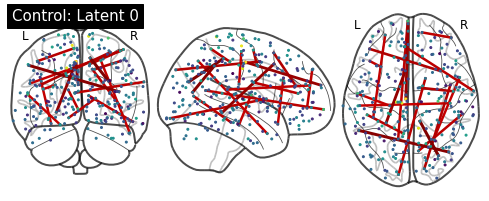

plots/2011/vae_2011_data_Autism_l0


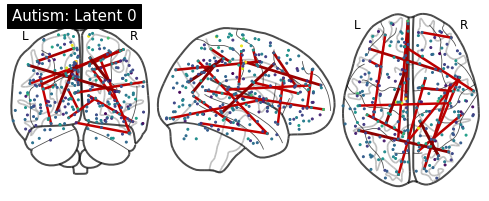

plots/2011/vae_2011_data_Control_l1


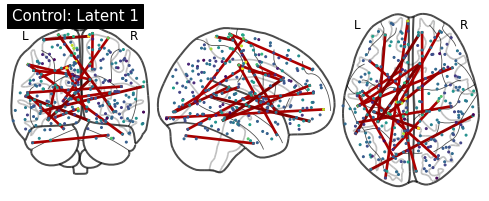

plots/2011/vae_2011_data_Autism_l1


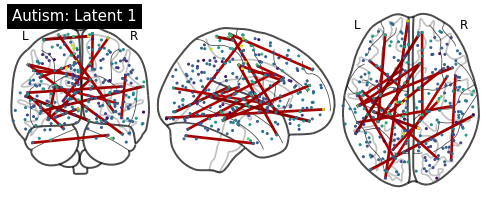

plots/2011/vae_2011_data_Control_l2


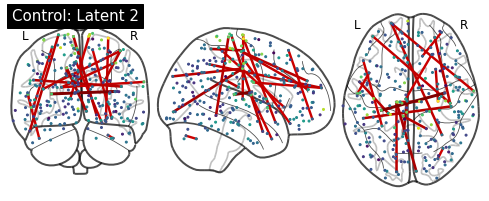

plots/2011/vae_2011_data_Autism_l2


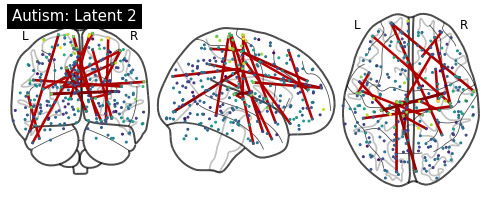

plots/2011/vae_2011_data_Control_l3


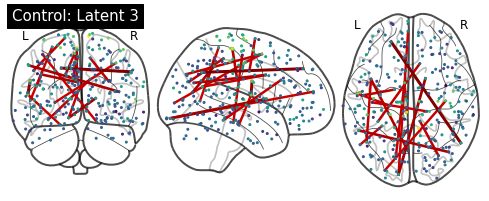

plots/2011/vae_2011_data_Autism_l3


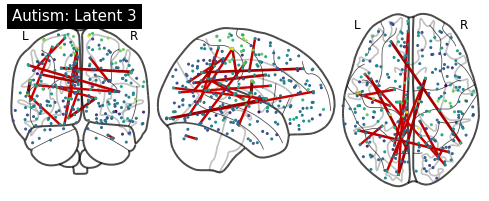

plots/2011/vae_2011_data_Control_l4


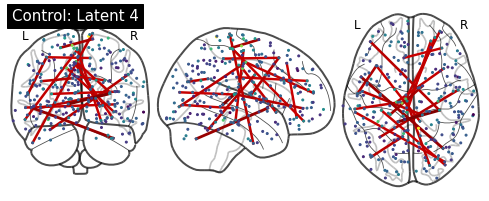

plots/2011/vae_2011_data_Autism_l4


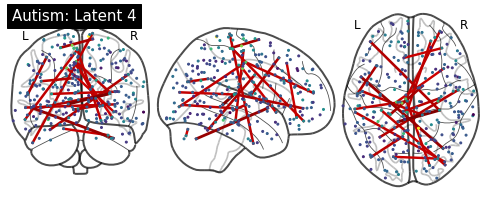

In [23]:
diags = ['Control', 'Autism']
mat_list_control = diag_to_mat[0]
mat_list_autism = diag_to_mat[1]
model_type = model_name.split("_")[1]
save_dir = os.path.join("plots", model_type)

edge_threshold = "99.95%"

for latent in range(5):
    curr_autism = mat_list_autism[latent]
    curr_control = mat_list_control[latent]
    glass_brain_plot(curr_autism, latent, diags[0], edge_threshold=edge_threshold, save_title="vae_{}_data_{}_l{}".
                     format(model_type, diags[0], latent), save_dir=save_dir)
    glass_brain_plot(curr_control, latent, diags[1], edge_threshold=edge_threshold, save_title="vae_{}_data_{}_l{}".
                     format(model_type, diags[1], latent), save_dir=save_dir)

# contribution plots

In [24]:
def latent_network_contribution(latent_agg_mat, label_masks):
    network_contrib_dict = {'Networks':[], 'Contribution':[]}
    for label_pair, mask in label_masks.items():
        network_contrib_dict['Networks'].append(label_pair)
        network_contrib_dict['Contribution'].append(np.sum(mask*latent_agg_mat)/np.sum(mask))
    contrib_df = pd.DataFrame(network_contrib_dict)
    contrib_df.sort_values(by='Contribution', ascending=False, inplace=True, ignore_index=True)
    return contrib_df

def network_significance(contrib_df, network_labels):
    network_dict = {label:0 for label in network_labels}
    for _, row in contrib_df.iterrows():
        (network_x, network_y) = row['Networks']
        contrib = row['Contribution']
        network_dict[network_x] += contrib
        network_dict[network_y] += contrib
    sig_df = pd.DataFrame({"Network":list(network_dict.keys()), "Contribution":list(network_dict.values())})
    sig_df.sort_values(by='Contribution', ascending=False, inplace=True, ignore_index=True)
    return sig_df

def plot_network_contribution(mat, title, latent, top_count=None):
    contrib_df = latent_network_contribution(mat, label_masks)
    if top_count is not None:
        top = contrib_df.head(top_count)
    else:
        top = contrib_df
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize = (8,4))
    ax = sns.barplot(y=top['Networks'], x=top['Contribution'], orient='h')
    ax.set_title("{}: Latent {}".format(title, latent))
    plt.show()

def plot_network_significance(mat, title, latent=None, network_labels=None):
    contrib_df = latent_network_contribution(mat, label_masks)
    sig_df = network_significance(contrib_df, network_labels)
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize = (8,4))
    ax = sns.barplot(y=sig_df['Network'], x=sig_df['Contribution'], orient='h')
    if latent is not None:
        ax.set_title("{}: Latent {}".format(title, latent))
    else:
        ax.set_title(title)
    plt.show()

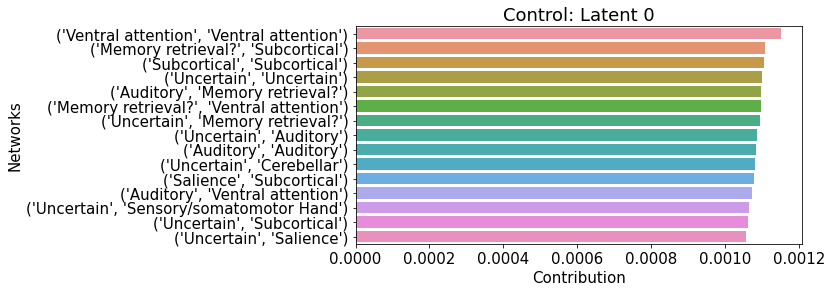

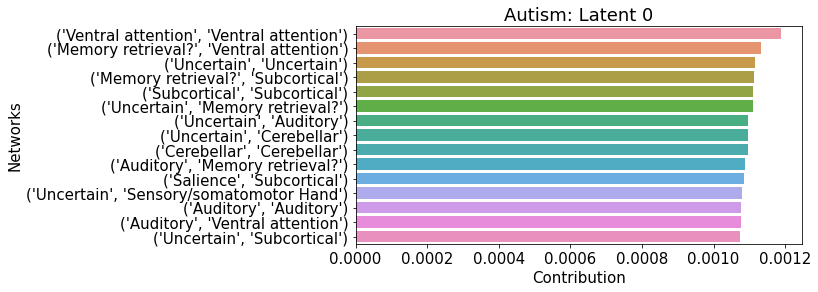

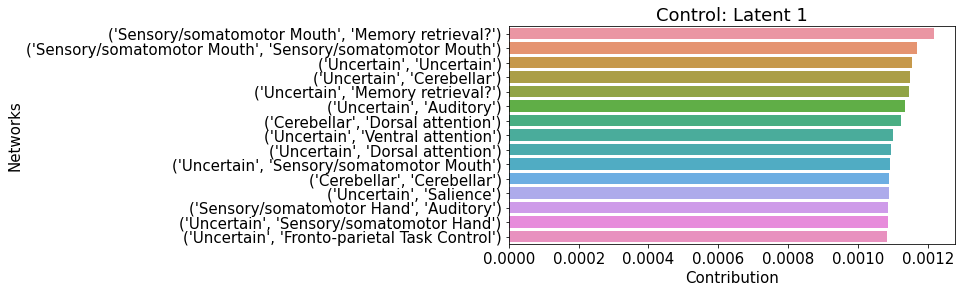

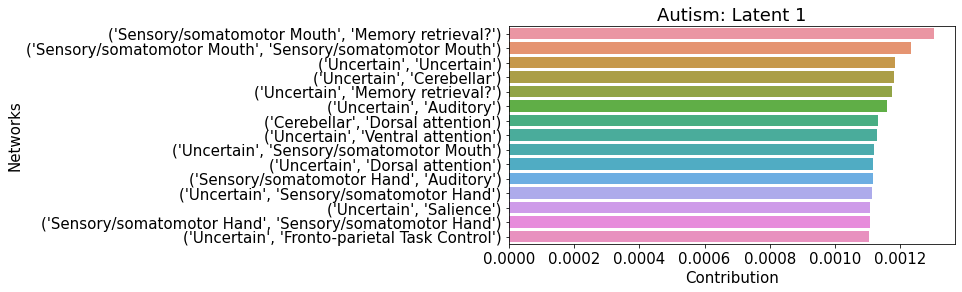

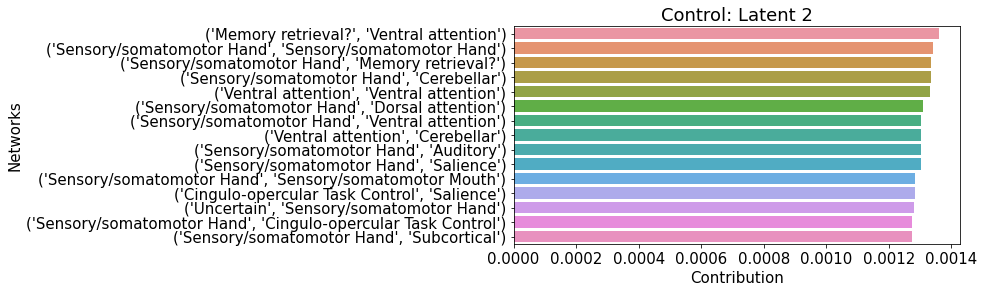

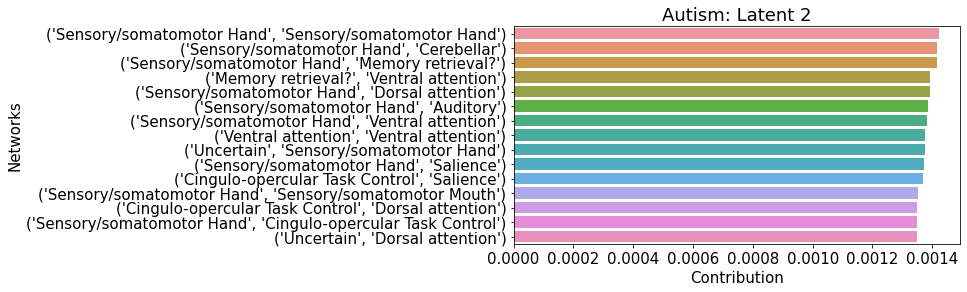

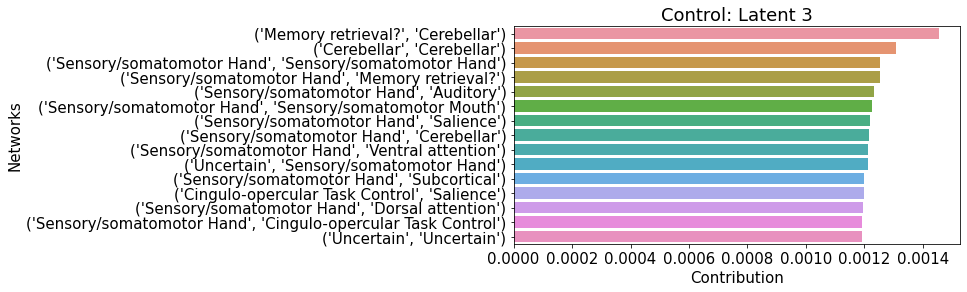

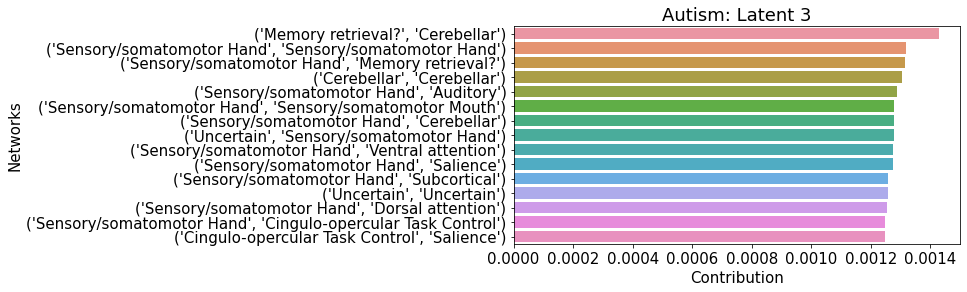

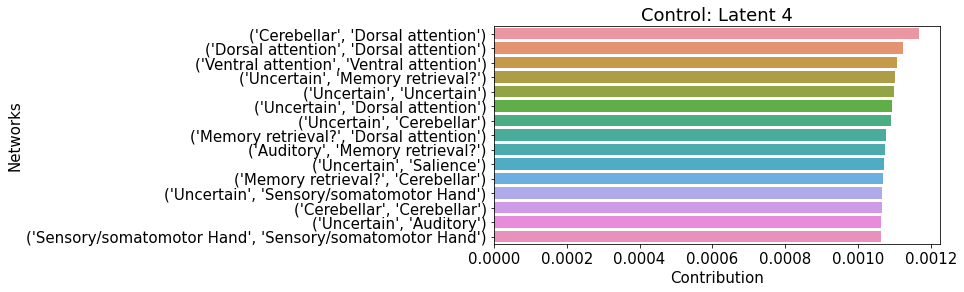

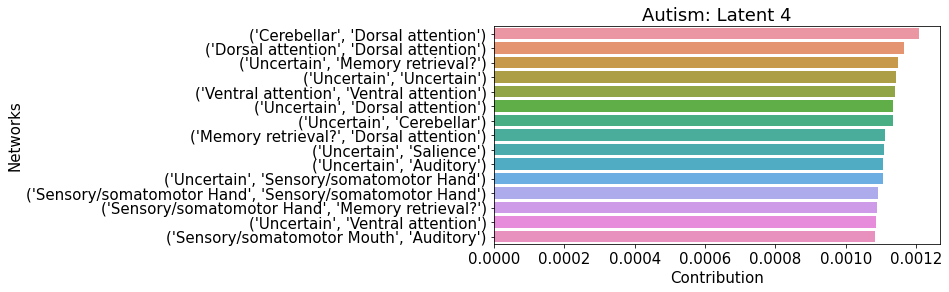

In [25]:
diags = ['Control', 'Autism']
mat_list_control = diag_to_mat[0]
mat_list_autism = diag_to_mat[1]
for latent in range(5):
    mat = mat_list_control[latent]
    mat = format_latent_mat(mat)
    plot_network_contribution(mat, diags[0], latent, 15)
    mat = mat_list_autism[latent]
    mat = format_latent_mat(mat)
    plot_network_contribution(mat, diags[1], latent, 15)

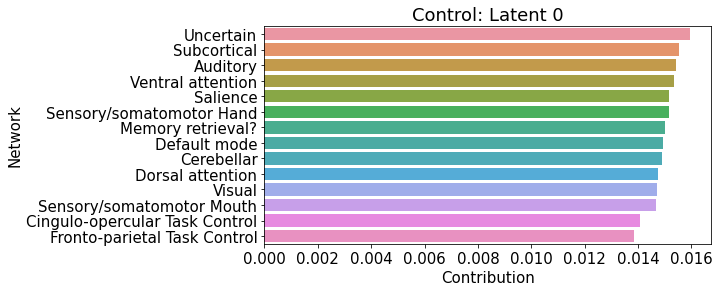

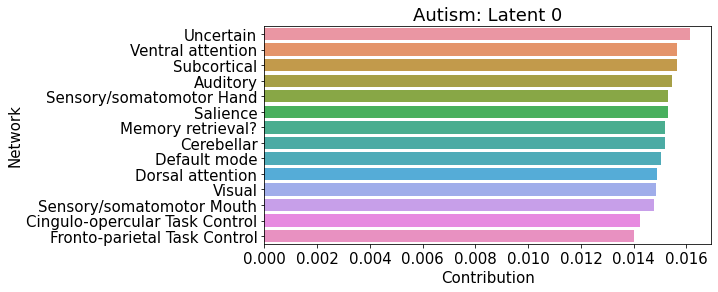

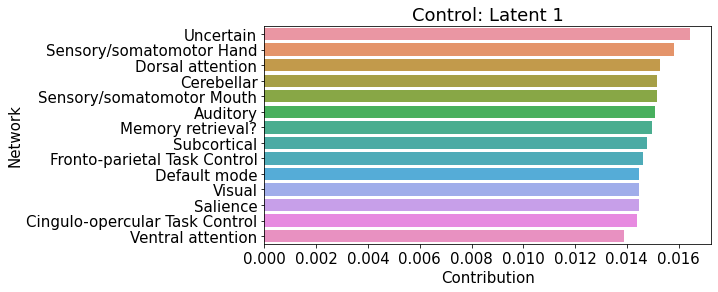

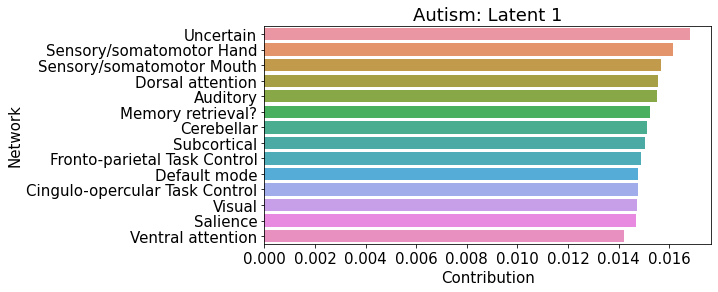

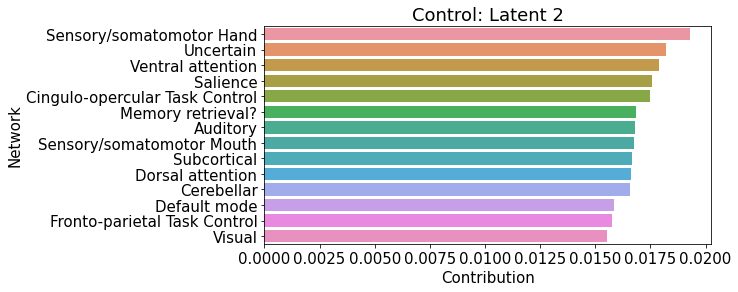

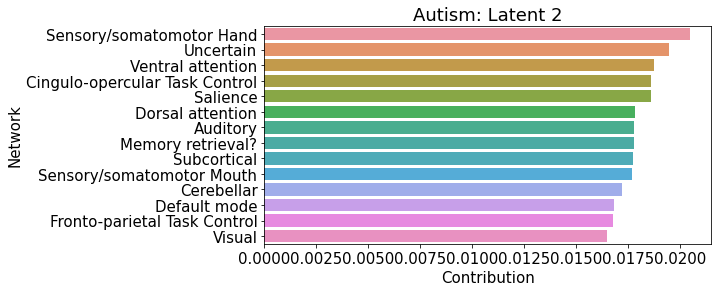

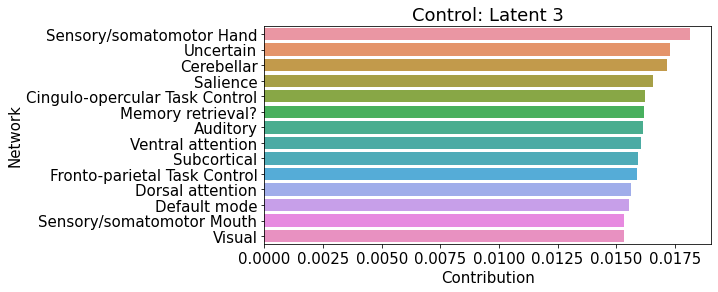

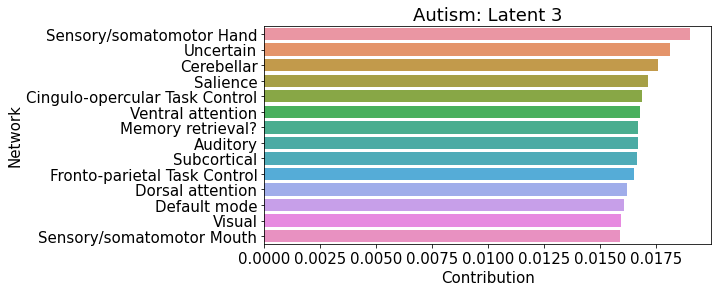

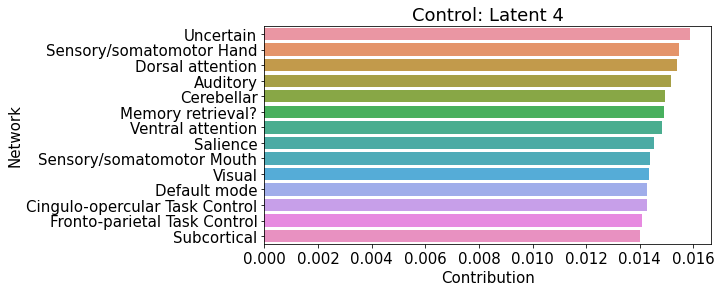

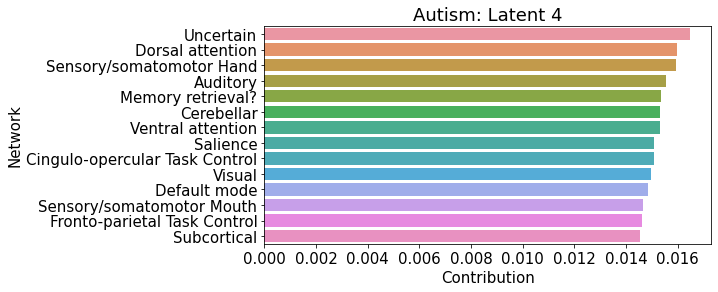

In [26]:
diags = ['Control', 'Autism']
mat_list_control = diag_to_mat[0]
mat_list_autism = diag_to_mat[1]
for latent in range(5):
    mat = mat_list_control[latent]
    mat = format_latent_mat(mat)
    plot_network_significance(mat, diags[0], latent, label_list)
    mat = mat_list_autism[latent]
    mat = format_latent_mat(mat)
    plot_network_significance(mat, diags[1], latent, label_list)

# t test

In [ ]:
atlas_want = 'power_2011'
qc = np.load(os.path.join('data', 'autism_qc.npy'))
# get all data & demo info
label = np.load(os.path.join('data', 'autism_labels.npy'))
label_qc = label[qc ==1]

site = np.load(os.path.join('data', 'autism_site.npy'))
site_qc = site[qc ==1]

age = np.load(os.path.join('data', 'autism_age.npy'))
age_qc = age[qc ==1]

sex = np.load(os.path.join('data', 'autism_sex.npy'), allow_pickle=True)
sex[sex =='F'] = 0
sex[sex =='M'] = 1
sex = sex.astype(str).astype(int)
sex_qc = sex[qc ==1]

data = np.load(os.path.join('data', 'fmri_'+atlas_want+'_cor.npy'))
data_qc = data[qc ==1,:]
# combat
data_adj_qc = np.load(os.path.join('data', 'fmri_'+atlas_want+'_cor_adj.npy'))
data_qc = data_adj_qc

In [ ]:
autism_data_qc = data_qc[label_qc == 1]
control_data_qc = data_qc[label_qc == 0]

In [ ]:
autism_dataset = PatientDataSet(pd.DataFrame(autism_data_qc))
trans = transforms.Compose([GaussianNoise(0,0.1,autism_dataset.data_columns),ToTorchFormat()])
autism_dataset.transform = trans

In [ ]:
control_dataset = PatientDataSet(pd.DataFrame(control_data_qc))
trans = transforms.Compose([GaussianNoise(0,0.1,control_dataset.data_columns),ToTorchFormat()])
control_dataset.transform = trans

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
control_mats = control_dataset.df[control_dataset.brain_columns].to_numpy()
control_mats = np.array([format_latent_mat(patient_mat) for patient_mat in control_mats])
autism_mats = autism_dataset.df[autism_dataset.brain_columns].to_numpy()
autism_mats = np.array([format_latent_mat(patient_mat) for patient_mat in autism_mats])

In [ ]:
t_stat, p_val = ttest_ind(control_mats, autism_mats, equal_var=False)

In [ ]:
thresh_05 = (p_val < 0.05).astype(int)
thresh_01 = (p_val < 0.01).astype(int)
print(np.sum(thresh_05)/thresh_05.size)
print(np.sum(thresh_01)/thresh_01.size)

In [ ]:
plot_network_significance(np.square(t_stat), "T Scores", network_labels=label_list)
plot_network_significance(thresh_05, "$P \leq 0.05$", network_labels=label_list)
plot_network_significance(thresh_01, "$P \leq 0.01$", network_labels=label_list)